# **NLP Fake News Classifier Model Development Notebook**

This notebook will serve as an environment to develop the fake news classifier for our web application. For future development phases, I hope this notebook will serve you well in terms of how the model is made, and its overall documentation in your development.

In this notebook, we aim to achieve the following:

- Load the dataset and prepare the Tagalog Fake News [dataset](https://huggingface.co/datasets/jcblaise/fake_news_filipino) for preprocessing
- Preprocess the dataset for training.
  - Use the following tools at your disposal, since Tagalog is a low-resource language:
    - [stopwords-tl](https://github.com/stopwords-iso/stopwords-tl)
    - [tagalog-stemmer](https://github.com/andrianllmm/tagalog-stemmer)
    - [calamanCy](https://github.com/ljvmiranda921/calamanCy)
- Train the following machine learning models:
  - Logistic Regression
  - Multinomial Naive Bayes
  - Support Vector Machine
  - Random Forests
- Evaluate the performance of each machine learning model
- Use 3-5 trained models for the ensemble approach
- Perform inference on sample data with [LIME](https://github.com/marcotcr/lime.git)

## **OBJECTIVE 1** 

Load the two Tagalog Fake News dataset for preprocessing ([here](https://huggingface.co/datasets/jcblaise/fake_news_filipino), and [here](https://github.com/aaroncarlfernandez/Philippine-Fake-News-Corpus))

In [38]:
from datasets import load_dataset
dataset_dict = load_dataset("jcblaise/fake_news_filipino", trust_remote_code=True)

dataset = dataset_dict['train']

labels = []
articles = []
for data in dataset:
    labels.append(data['label'])
    articles.append(data['article'])

For our second dataset, we will only take the `Content` and `Label` features.

In [39]:
import pandas as pd
df = pd.read_csv('./data/Philippine Fake News Corpus.csv')
df.dropna()
df = df[['Content', 'Label']]
df.head()

,Content,Label
0,Pollution caused by traditional cooking fuel i...,Credible
1,Justice Secretary Vitaliano Aguirre 2nd and Ph...,Credible
2,President Rodrigo Duterte on Monday night desc...,Credible
3,THE militant fisher folk group Pambansang Laka...,Credible
4,Magdalo Rep. Gary Alejano is willing to lead t...,Credible


In [40]:
# Custom mapping
labels2 = list(df['Label'].map({'Credible': 0, 'Not Credible': 1})) # 0: Real News, 1: Fake News
articles2 = list(df['Content'].values)

In [41]:
len(labels), len(articles)

(3206, 3206)

In [42]:
len(labels2), len(articles2)

(22458, 22458)

In [43]:
# combine two lists
labels.extend(labels2)
articles.extend(articles2)

In [44]:
len(labels), len(articles)

(25664, 25664)

Now that our dataset is separated into lists, we can transfer them to `pandas`' dataframe object for ease of use.

In [45]:
import pandas as pd
df = pd.DataFrame({
    "articles": articles,
    "labels": labels
})
df.head()

,articles,labels
0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",0
1,Kilala rin ang singer sa pagkumpas ng kanyang ...,0
2,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",0
3,"Kasama sa programa ang pananalangin, bulaklak ...",0
4,Linisin ang Friendship Department dahil dadala...,0


In [48]:
# let's shuffle first to ensure both dataset are scattered throughout the df
from sklearn.utils import shuffle

# Shuffle entire DataFrame
df = shuffle(df, random_state=42)
df.head()

,articles,labels
1664,Inuulan ngayon ng batikos ang dilawang mamamah...,1
8849,The passage of the proposed 2019 P3.757 trilli...,0
9792,House Majority Leader Neptali Gonzales II: Bet...,0
25147,taped greeting to former President Fidel V. Ra...,0
18783,I recently shared my colleague Benign0’s artic...,1


This is actually enough. But before we proceed, we need to ensure data integrity before we send it to preprocessing.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25664 entries, 0 to 25663
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   articles  25664 non-null  object
 1   labels    25664 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 401.1+ KB


So far, we have correct data types, complete number of data, and is of non-null.

Let's see the distribution of word counts to see if there are outliers.

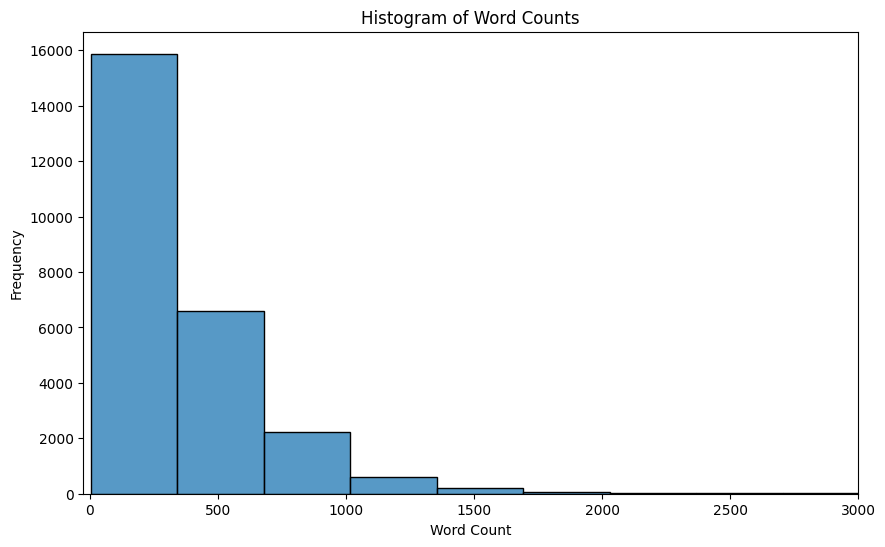

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

word_counts = [len(text.split()) for text in articles]

plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=50)
plt.title('Histogram of Word Counts')
plt.xlim(-25, 3000)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Notice that we have an unusual word count (over 400!) of articles between 0 and 200. Let's plot the word count for each class and see the word count distribution for each class.

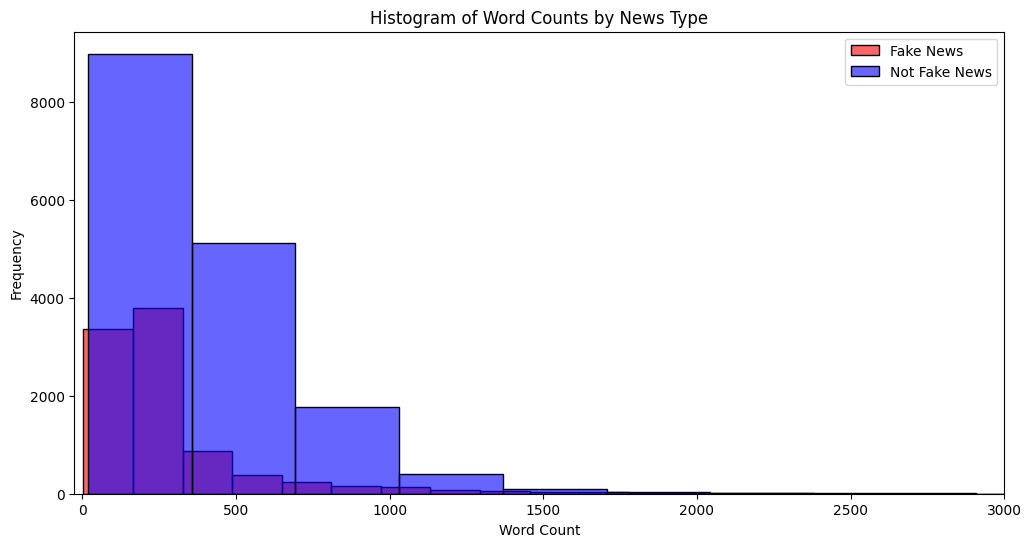

In [55]:
df['word_count'] = df['articles'].apply(lambda x: len(x.split()))

# Plotting the histograms
plt.figure(figsize=(12, 6))
sns.histplot(df[df['labels'] == 1]['word_count'], bins=50, kde=False, color='red', label='Fake News', alpha=0.6)
sns.histplot(df[df['labels'] == 0]['word_count'], bins=50, kde=False, color='blue', label='Not Fake News', alpha=0.6)

plt.title('Histogram of Word Counts by News Type')
plt.xlabel('Word Count')
plt.xlim(-25, 3000)
plt.ylabel('Frequency')
plt.legend()

plt.show()

Interesting. It seems that most articles that are not fake news are over 8000 instances, while the fake news are considerably lower.

We need to take this into account when training, as it may not be able to generalize well, or perhaps even overfit in the not fake news class due to high word count.

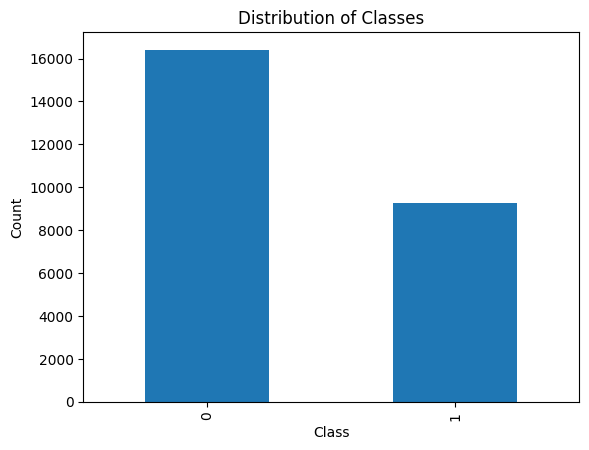

In [61]:
df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## **OBJECTIVE 2**
- Preprocess the dataset for training.
  - Use the following tools at your disposal, since Tagalog is a low-resource language:
    - [stopwords-tl](https://github.com/stopwords-iso/stopwords-tl)
    - [tagalog-stemmer](https://github.com/andrianllmm/tagalog-stemmer)
    - or use [calamanCy](https://github.com/ljvmiranda921/calamanCy) for lemmatization

In [2]:
from pathlib import Path
def load_stopwords(path: Path = Path("./stopwords-tl.txt")):
    """ Opens the tagalog stopwords file """
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

In [3]:
import nltk
import calamancy

nlp = calamancy.load("tl_calamancy_md-0.2.0")
tagalog_tl = load_stopwords()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\spacy\util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.2.0) specifies an under-constrained spaCy version requirement: >=3.8.3. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.8.5,<3.9.0
  warnings.warn(warn_msg)
c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pyt

True

In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(txt: str, calamancy_model, tl_stopwords, join: bool=True):
    """
    Preprocesses input text by converting it to lowercase,
    removing punctuation, applying Tagalog & English stopword removal,
    and performing Tagalog & English lemmatization.

    Args:
        txt (str): Input text
        calamancy_model: calamanCy model for Tagalog lemmatization
        tl_stopwords (list): Tagalog stopword list
        join (bool): Whether to return a joined string or list of tokens
    """
    # Initialize English tools
    en_stopwords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Step 1: Lowercase
    lower_text = txt.lower()

    # Step 2: Remove punctuation
    no_punc = lower_text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenize
    tokenized = word_tokenize(no_punc)

    # Step 4: Remove Tagalog and English stopwords
    tokens_no_stop = [
        token for token in tokenized
        if token not in tl_stopwords and token not in en_stopwords
    ]

    # Step 5: Lemmatize with calamancy (Tagalog)
    calamancy_doc = calamancy_model(' '.join(tokens_no_stop))
    calamancy_lemmas = [token.lemma_ for token in calamancy_doc]

    # Step 6: Lemmatize again with English lemmatizer (handles English tokens better)
    final_tokens = [lemmatizer.lemmatize(token) for token in calamancy_lemmas]

    # Step 7: Return
    if join:
        return ' '.join(final_tokens)
    else:
        return final_tokens

In [79]:
# apply prepreocessing sample
sample_text = df['articles'].sample().item()
print(sample_text)
print(preprocess_text(str(sample_text), nlp, tagalog_tl, True))

Umabante ang Americans sa playoffs sa Abril at may tsansang makabalik sa World Group na bubuuin ng top eight teams. Dinispatsa ni Venus Williams, ika-11 sa mundo, ang pag-asa ng Argentina na makabalik matapos niyang talunin si Maria Irigoyen, 6-1, 6-4.
abante american playoff abril tsansa na balik world group bubuuin top eight team dinispatsa venus williams ika11 mundo pagasa argentina balik tapos talon si maria irigoyen 61 64


In [ ]:
# preprocessing the text
# df['processed_text'] = df['articles'].apply(lambda doc: preprocess_text(doc, nlp, tagalog_tl, True))

In [87]:
df.head()

,articles,labels,word_count,processed_text
1664,Inuulan ngayon ng batikos ang dilawang mamamah...,1,95,inuulan batikos dilawa na hayag si philip lust...
8849,The passage of the proposed 2019 P3.757 trilli...,0,625,passage proposed 2019 p3757 trillion national ...
9792,House Majority Leader Neptali Gonzales II: Bet...,0,1053,house majority leader neptali gonzales ii bett...
25147,taped greeting to former President Fidel V. Ra...,0,857,taped greeting former president fidel v ramos ...
18783,I recently shared my colleague Benign0’s artic...,1,2359,recently shared colleague benign0 ’ article fa...


In [88]:
df.to_csv('./data/processed.csv', index=False)

In [1]:
import pandas as pd
new_df = pd.read_csv('./data/processed.csv')
new_df.head()

,articles,labels,word_count,processed_text
0,Inuulan ngayon ng batikos ang dilawang mamamah...,1,95,inuulan batikos dilawa na hayag si philip lust...
1,The passage of the proposed 2019 P3.757 trilli...,0,625,passage proposed 2019 p3757 trillion national ...
2,House Majority Leader Neptali Gonzales II: Bet...,0,1053,house majority leader neptali gonzales ii bett...
3,taped greeting to former President Fidel V. Ra...,0,857,taped greeting former president fidel v ramos ...
4,I recently shared my colleague Benign0’s artic...,1,2359,recently shared colleague benign0 ’ article fa...


In [5]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25664 entries, 0 to 25663
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   articles        25664 non-null  object
 1   labels          25664 non-null  int64 
 2   word_count      25664 non-null  int64 
 3   processed_text  25664 non-null  object
dtypes: int64(2), object(2)
memory usage: 802.1+ KB


## **OBJECTIVE 3 & 4**

Train the following machine learning models:
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Machine
- Random Forests

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    new_df['processed_text'], new_df['labels'], test_size=0.2, random_state=42)

In [10]:
from joblib import dump, load
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# dump(vectorizer, "./serialized/tfidf-vectorizer.pkl")

vectorizer = load("./serialized/tfidf-vectorizer.pkl")

In [13]:
models = {
    "LogisticRegression": LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        C=1.0, 
        n_jobs=-1, 
        solver='saga'
    ),
    "MultinomialNB": MultinomialNB(),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=75, 
        class_weight='balanced', 
        max_depth=12, 
        n_jobs=-1
    ),
    "SGDC": CalibratedClassifierCV(
            SGDClassifier(
            loss='hinge',
            alpha=1/(1.0 * len(X_train)),  # Proper scaling
            class_weight='balanced',
            max_iter=1000,
            n_jobs=-1
        ),
        method='sigmoid',
        cv=3,
        n_jobs=-1
    )
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    dump(model, f"./serialized/models/{name}.pkl")
    print(f"✅ Done training and saving {name}")

results_df = pd.DataFrame(results).T

Training LogisticRegression...
✅ Done training and saving LogisticRegression
Training MultinomialNB...
✅ Done training and saving MultinomialNB
Training RandomForestClassifier...
✅ Done training and saving RandomForestClassifier
Training SGDC...
✅ Done training and saving SGDC


In [14]:
results_df

,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.937269,0.899842,0.928222,0.913812
MultinomialNB,0.761543,0.914980,0.368679,0.525581
RandomForestClassifier,0.849016,0.734775,0.905383,0.811206
SGDC,0.950127,0.942921,0.916259,0.929399


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

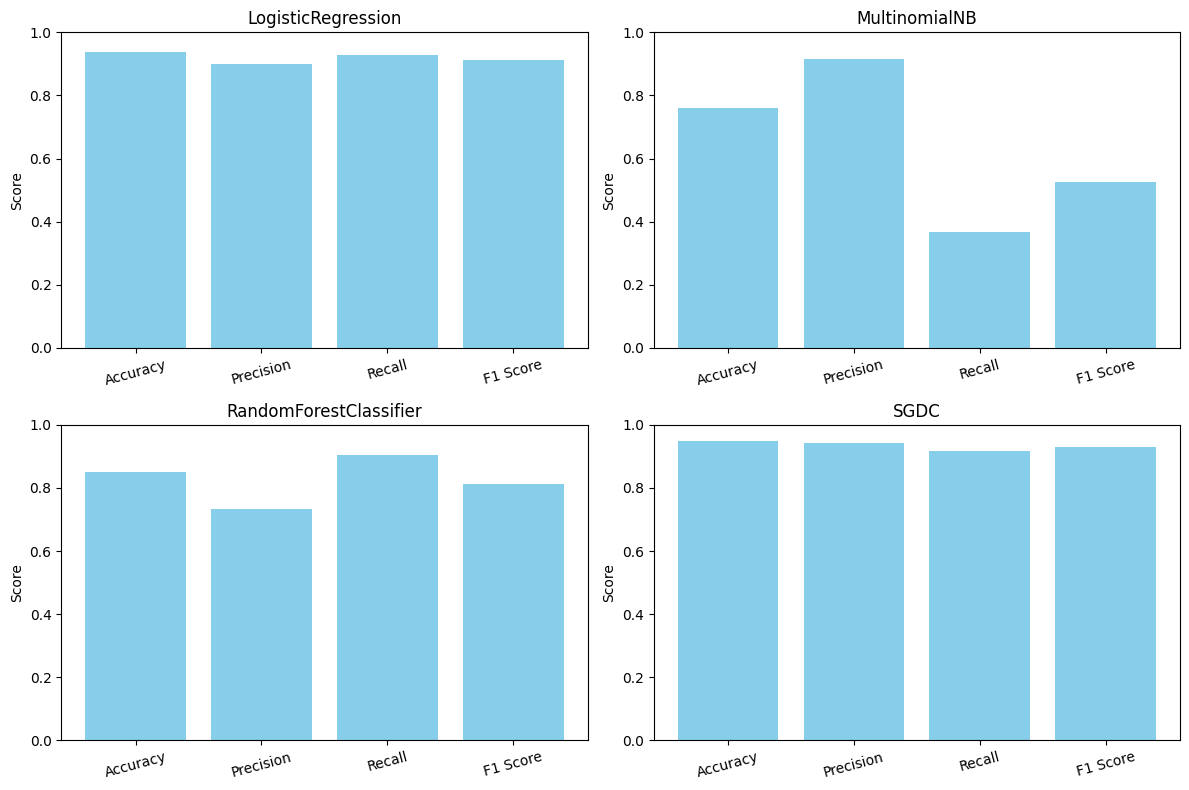

In [16]:
df_plot = results_df.copy()

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, metric in enumerate(df_plot.index):
    axes[i].bar(df_plot.columns, df_plot.loc[metric], color='skyblue')
    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Score")
    axes[i].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## **OBJECTIVE 5**

Use 3-5 trained models for the ensemble approach

For our ensemble approach, let's use logistic regression, SVM, and random forests.

In [17]:
from sklearn.ensemble import VotingClassifier

logreg = LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        C=1.0, 
        n_jobs=-1, 
        solver='saga'
    )
mnb = MultinomialNB()
rf = RandomForestClassifier(
        n_estimators=75, 
        class_weight='balanced', 
        max_depth=12, 
        n_jobs=-1
    )
sgdc = CalibratedClassifierCV(
            SGDClassifier(
            loss='hinge',
            alpha=1/(1.0 * len(X_train)),  # Proper scaling
            class_weight='balanced',
            max_iter=1000,
            n_jobs=-1
        ),
        method='sigmoid',
        cv=3,
        n_jobs=-1
    )

voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('mnb', mnb),
        ('rf', rf),
        ('sgdc', sgdc)
    ],
    voting='soft',
)

voting_clf.fit(X_train_tfidf, y_train)
y_pred = voting_clf.predict(X_test_tfidf)

ensemble_results = {}

ensemble_results['SoftVoting'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

# Update results DataFrame
res = pd.DataFrame(ensemble_results)
dump(voting_clf, "./serialized/models/EnsembleSoftVoting.pkl")

res.head()

,SoftVoting
Accuracy,0.937074
Precision,0.954436
Recall,0.865688
F1 Score,0.907898


## **OBJECTIVE 6**

Perform inference on sample data with [LIME](https://github.com/marcotcr/lime.git)

In [18]:
# Randomly sample one row from the DataFrame
sample = new_df.sample()
print(f"Original: {sample.values[0]}")

# Extract the text and label as raw values
sample_text = preprocess_text(sample['articles'].values[0], nlp, tagalog_tl, True)
label = sample['labels'].values[0]

print(sample_text, type(sample_text))
print(label, type(label))

Original: ['A CCTV Footage was released to the media showing Tanauan City Mayor Tony Halili dropped dead after a sniper gunned him down. The incident during the City Hall’s flag ceremony.Halili became controversial with his “Walk of Shame” where he paraded drug suspects in the street as punishment.President Rody Duterte said that he suspected that the death of Halili is linked to drug trading. Duterte likened Halili with the drug dealers and Mayors Parojinogs and Espinos who were also shot dead on 2017.Vantage PointInvestigators discovered the possible location of the sniper’s vantage area which is a few steps away only from Mayor Halili.Click Below To Watch VideoYour thoughts on this? Leave your comments below!'
 1 113
 'cctv footage released medium showing tanao city mayor tony halili dropped dead sniper gunned incident city hall ’ flag ceremonyhalili became controversial “ walk shame ” paraded drug suspect street punishmentpresident rody duterte said suspected death halili linked dr

In [19]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import numpy as np

from sklearn.pipeline import make_pipeline

model = load('./serialized/models/EnsembleSoftVoting.pkl')  # Load any model you want to interpret

# Wrap vectorizer and model into one pipeline
c = make_pipeline(vectorizer, model)

class_names = ["Real News", "Fake News"] # 0, 1

In [20]:
explainer = LimeTextExplainer(class_names=class_names)

exp = explainer.explain_instance(sample_text, c.predict_proba, num_features=10)

exp.save_to_file('./figures/sample_lime_explanation.html')

In [21]:
# get pred prob
exp.predict_proba.max()

np.float64(0.6221725179770617)

In [22]:
exp.as_list()

[(np.str_('comment'), 0.050340713408320324),
 (np.str_('rody'), 0.05031333112644827),
 (np.str_('said'), -0.045464148486823314),
 (np.str_('duterte'), 0.03558774393517141),
 (np.str_('halili'), -0.03129729800207309),
 (np.str_('leave'), 0.028336438393217426),
 (np.str_('thought'), 0.027518806954273355),
 (np.str_('city'), -0.02531951740454136),
 (np.str_('watch'), 0.022099284628332137),
 (np.str_('area'), -0.021295620165688964)]